In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from pykalman import KalmanFilter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def to_timestamp(d):
    return d.timestamp()

In [2]:
file = 'sysinfo.csv'
#file = sys.argv[1]
cpu_data = pd.read_csv(file, parse_dates=[4])
cpu = cpu_data.sort_values(by = 'temperature')

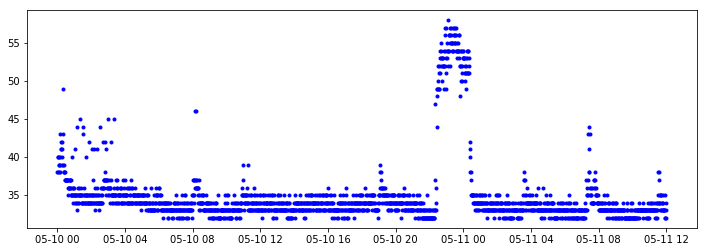

In [3]:
plt.figure(figsize=(12,4))
plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.')
plt.show() # maybe easier for testing
#plt.savefig('cpu.svg') # for final submission

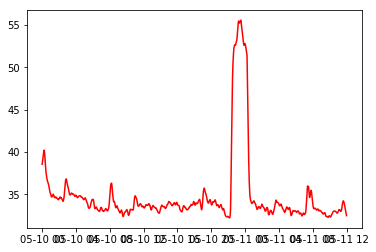

In [4]:
cpu_data['temp_time']=cpu_data['timestamp'].apply(to_timestamp)
#lowess = sm.nonparametric.lowess
loess_smoothed = lowess(cpu_data['temperature'],cpu_data['timestamp'],frac=0.01)
plt.plot(cpu_data['timestamp'], loess_smoothed[:, 1], 'r-')

In [10]:
kalman_data = cpu_data[['temperature', 'cpu_percent', 'sys_load_1']]
initial_state = kalman_data.iloc[0]
observation_covariance = np.diag([1, 1, 1]) ** 2 # TODO: shouldn't be zero
transition_covariance = np.diag([0.1, 0.1, 0.1]) ** 2 # TODO: shouldn't be zero
transition = [[1, -1, 0.7], [0, 0.6, 0.03], [0, 1.3, 0.8]] # TODO: shouldn't (all) be zer

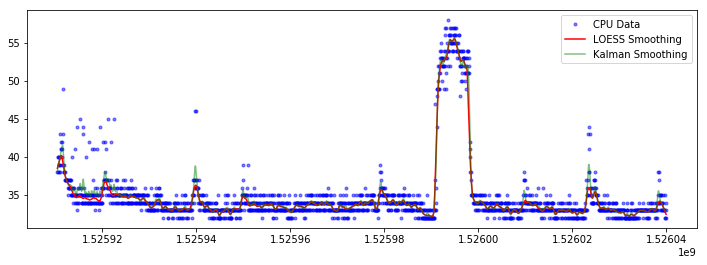

In [17]:
kf = KalmanFilter(
    initial_state_mean=initial_state,
    initial_state_covariance=observation_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance,
    transition_matrices=transition
)
kalman_smoothed, _ = kf.smooth(kalman_data)
plt.figure(figsize=(12, 4))
plt.plot(cpu_data['temp_time'], cpu_data['temperature'], 'b.', alpha = 0.5)
plt.plot(cpu_data['temp_time'], loess_smoothed[:, 1], 'r-')
plt.plot(cpu_data['temp_time'], kalman_smoothed[:, 0], 'g-', alpha = 0.5)
plt.legend(['CPU Data', 'LOESS Smoothing', 'Kalman Smoothing'])
plt.savefig('cpu.svg')